In [ ]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision.transforms import Resize
import matplotlib.pyplot as plt
from helpers import kl_factor, filter, show_jets, show_hist
from VAE import VAE

In [ ]:
## Parameters ##

cudnn.benchmark = True

# Batch size during training
batch_size = 2048

# Original image size
image_size = 100

# Images will be downsampled to this spatial size
input_size = 32

# Number of channels in the training images
nc = 1

# Size of z latent dimension
nz = 200

# Model dimensions
num_layers = int(np.log2(input_size))
nh = 128

# Weighting of KL divergence loss; use this if not using annealing
# kl_factor = 0.1

# Number of training epochs
num_epochs = 500

# Optimizer parameters
lr = 1e-5
beta1 = 0.9
beta2 = 0.999

# Use 0 for CPU mode and > 0 for GPU.
ngpu = 1

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


In [ ]:
##------------------------------------------------------------------------------------------------##
##  Data downloaded from CERN:                                                                    ##
##    ! curl https://cernbox.cern.ch/s/zZDKjltAcJW0RB7/download -o Data-ML-Jet-Project.tar.gz     ##
##------------------------------------------------------------------------------------------------##

In [ ]:
## Fetch data for Colab ##

! curl https://cernbox.cern.ch/s/zZDKjltAcJW0RB7/download -o Data-ML-Jet-Project.tar.gz
! tar -xvzf Data-ML-Jet-Project.tar.gz
! ls Data-MLtutorial/JetDataset/
! rm Data-ML-Jet-Project.tar.gz

file_set = ['Data-MLtutorial/JetDataset/jetImage_7_100p_80000_90000.h5',
            'Data-MLtutorial/JetDataset/jetImage_7_100p_70000_80000.h5',
            'Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5',
            'Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5',
            'Data-MLtutorial/JetDataset/jetImage_7_100p_40000_50000.h5',
            'Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5',
            'Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5',
            'Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5']

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  333M    0  333M    0     0  11.8M      0 --:--:--  0:00:28 --:--:-- 18.6M
Data-MLtutorial/
Data-MLtutorial/JetDataset/
Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_40000_50000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_70000_80000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_80000_90000.h5
jetImage_7_100p_0_10000.h5	jetImage_7_100p_40000_50000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_50000_60000.h5	jetImage_7_100p_80000_90000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_60000_70000.h5


In [ ]:
## Fetch data for local run ##

path = os.getcwd()
file_set = [path + '/Data/' + filename for filename in os.listdir(path = path + '/Data')]

In [ ]:
## Process Data ##

images_numpy = np.concatenate([np.array(h5py.File(f).get('jetImage')) for f in file_set]).reshape(-1, nc, image_size, image_size)
float_images = images_numpy.astype('float32')

# Resize
tensor_images = torch.from_numpy(float_images)
resized_tensor_images = Resize(size=input_size)(tensor_images)
print("Dataset shape: ", resized_tensor_images.shape)

dataloader = torch.utils.data.DataLoader(resized_tensor_images, batch_size=batch_size, shuffle=True)

Dataset shape:  torch.Size([80000, 1, 32, 32])


In [ ]:
## Initialize network ##

model = VAE(nc=nc, input_size=input_size, nh=nh, nz=nz, device = device).to(device)

print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

## Set up optimizer ##

optimizer = optim.Adam(model.parameters(), lr= lr, betas=(beta1, beta2))

Number of parameters:  94572432


In [ ]:
## Training Loop ##

# List to keep track of losses
loss_list = []

print("Starting Training Loop...")

# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, input in enumerate(dataloader, 0):

        optimizer.zero_grad()
        input = input.to(device)
        mu, log_var, output = model(input)
        recon_loss = F.mse_loss(input, output)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - torch.exp(log_var))
        loss = recon_loss + kl_loss * kl_factor(i, len(dataloader))
        loss.backward()
        optimizer.step()

        # Since we are using cyclical annealing, total loss will oscillate: more useful track just reconstruction loss
        loss_list.append(recon_loss.item())

    # Output training stats every epoch
    print('[%d/%d] \t \t Avg. recon loss: %.4f \t Avg. KL loss: %.4f' % (epoch, num_epochs, recon_loss.item(), kl_loss.item()))

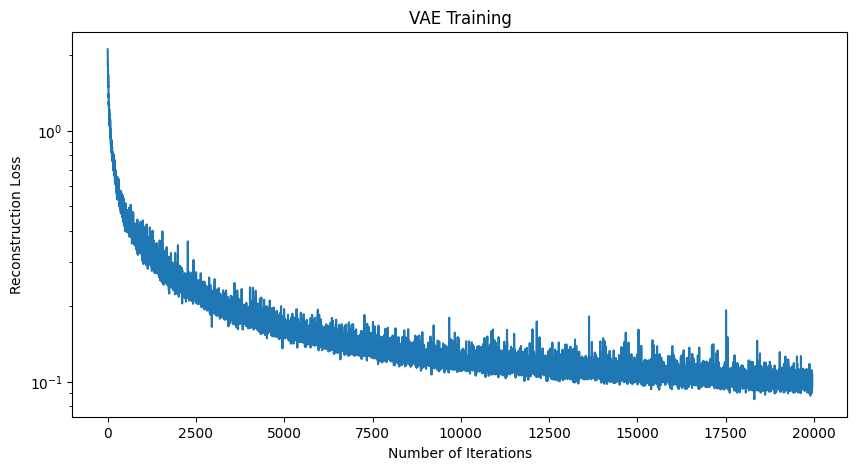

In [ ]:
## Loss Plot ##

plt.figure(figsize=(10,5))
plt.title("VAE Training")
plt.plot(loss_list[50:])
plt.yscale('log')
plt.xlabel("Number of Iterations")
plt.ylabel("Reconstruction Loss")
plt.show()

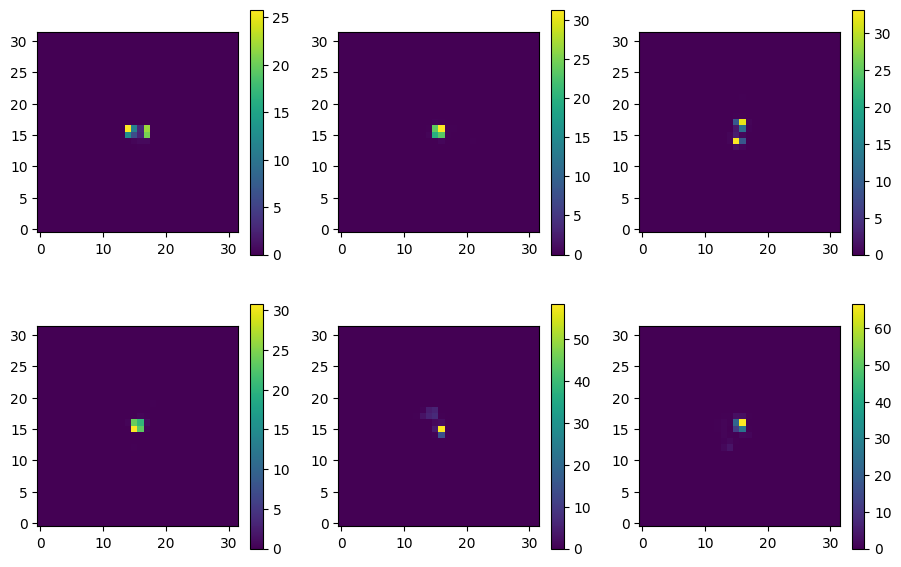

In [ ]:
## Some real images ##

show_jets(resized_tensor_images)

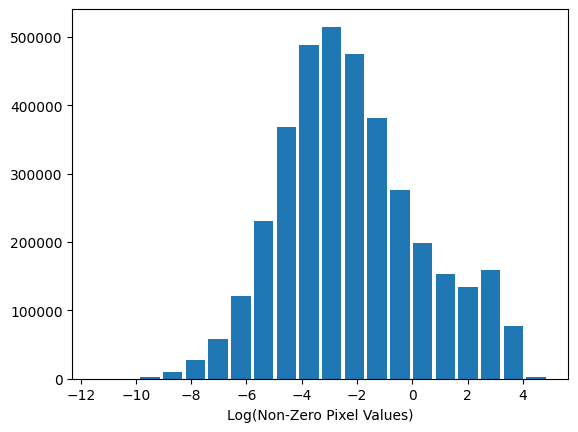

In [ ]:
## Distribution of pixel values for real images ##

show_hist(resized_tensor_images, resized_tensor_images)

In [ ]:
## Generating new images ##

gen_images = model.sample(batch_size)

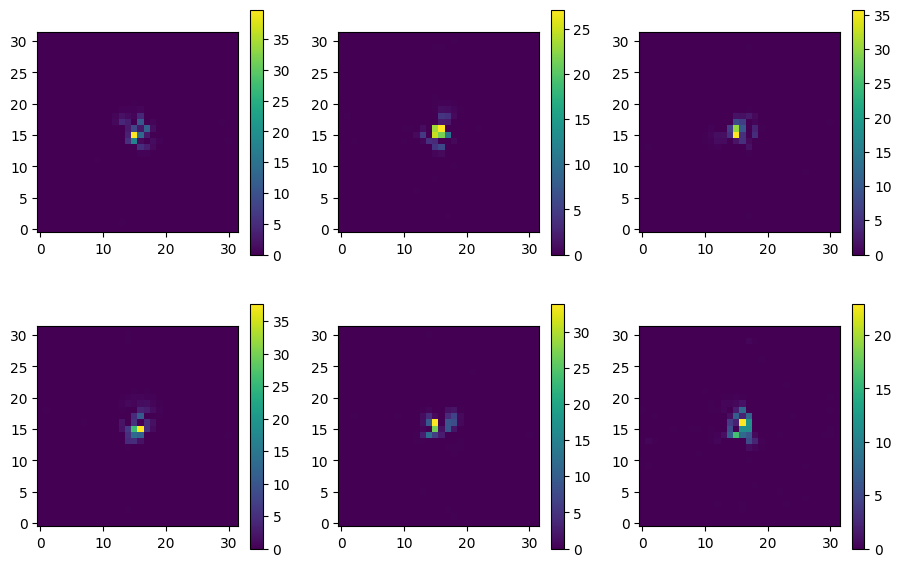

In [ ]:
## Sample of generated new images ##

show_jets(filter(gen_images, threshold=0.001))

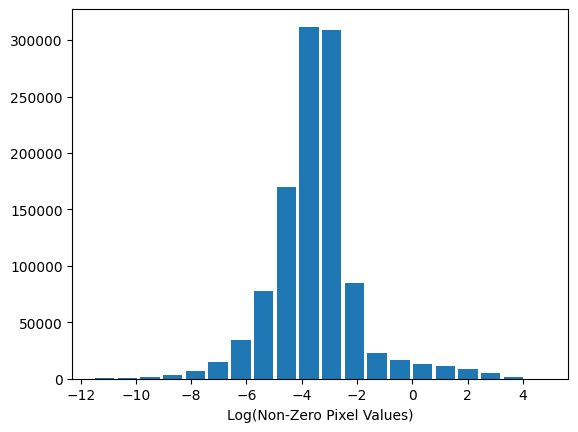

In [ ]:
## Distribution of pixel values for generated images ##

show_hist(resized_tensor_images, gen_images)

In [ ]:
## Download model from Google Colab ##

from google.colab import files

torch.save(model.state_dict(), 'VAE.pt')
files.download('VAE.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>